In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import os

# Grafik ayarları
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [19]:
class NeuralNetwork:
    """
    Çok katmanlı sinir ağı sınıfı - İleri ve geri yayılım algoritmaları ile
    """
    
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.01):
        """
        Sinir ağını başlat
        
        Args:
            input_size: Giriş katmanı nöron sayısı
            hidden_sizes: Gizli katman nöron sayıları listesi [64, 32] gibi
            output_size: Çıkış katmanı nöron sayısı
            learning_rate: Öğrenme oranı
        """
        self.learning_rate = learning_rate
        self.layers = []
        
        # Katman boyutları
        sizes = [input_size] + hidden_sizes + [output_size]
        
        # Ağırlık ve bias'ları rastgele başlat (He initialization)
        self.weights = []
        self.biases = []
        
        for i in range(len(sizes) - 1):
            # He initialization: sqrt(2/n_input)
            w = np.random.randn(sizes[i], sizes[i+1]) * np.sqrt(2.0 / sizes[i])
            b = np.zeros((1, sizes[i+1]))
            self.weights.append(w)
            self.biases.append(b)
        
        # Eğitim geçmişi
        self.loss_history = []
        self.accuracy_history = []
    
    def relu(self, x):
        """ReLU aktivasyon fonksiyonu"""
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        """ReLU türevi"""
        return (x > 0).astype(float)
    
    def softmax(self, x):
        """Softmax aktivasyon fonksiyonu (çıkış katmanı için)"""
        # Sayısal kararlılık için maksimum değeri çıkar
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward_propagation(self, X):
        """
        İleri yayılım algoritması
        
        Args:
            X: Giriş verisi (batch_size, input_features)
            
        Returns:
            activations: Her katmanın aktivasyon değerleri
            z_values: Her katmanın linear kombinasyon değerleri
        """
        activations = [X]
        z_values = []
        
        current_input = X
        
        for i in range(len(self.weights)):
            # Linear kombinasyon: z = XW + b
            z = np.dot(current_input, self.weights[i]) + self.biases[i]
            z_values.append(z)
            
            # Aktivasyon fonksiyonu
            if i == len(self.weights) - 1:  # Çıkış katmanı
                activation = self.softmax(z)
            else:  # Gizli katmanlar
                activation = self.relu(z)
            
            activations.append(activation)
            current_input = activation
        
        return activations, z_values
    
    def backward_propagation(self, X, y, activations, z_values):
        """
        Geri yayılım algoritması
        
        Args:
            X: Giriş verisi
            y: Gerçek etiketler (one-hot encoded)
            activations: İleri yayılımdan gelen aktivasyonlar
            z_values: İleri yayılımdan gelen z değerleri
        """
        m = X.shape[0]  # Batch boyutu
        
        # Gradyanları sakla
        dW = [np.zeros_like(w) for w in self.weights]
        db = [np.zeros_like(b) for b in self.biases]
        
        # Çıkış katmanından geriye doğru
        # Çıkış katmanı hatası (softmax + cross-entropy için)
        delta = activations[-1] - y
        
        for i in reversed(range(len(self.weights))):
            # Gradyanları hesapla
            dW[i] = np.dot(activations[i].T, delta) / m
            db[i] = np.sum(delta, axis=0, keepdims=True) / m
            
            if i > 0:  # Gizli katmanlar için
                # Hatayı önceki katmana yay
                delta = np.dot(delta, self.weights[i].T) * self.relu_derivative(z_values[i-1])
        
        return dW, db
    
    def update_parameters(self, dW, db):
        """Gradyan iniş ile parametreleri güncelle"""
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * dW[i]
            self.biases[i] -= self.learning_rate * db[i]
    
    def compute_loss(self, y_true, y_pred):
        """Cross-entropy loss hesapla"""
        m = y_true.shape[0]
        # Sayısal kararlılık için küçük epsilon ekle
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -np.sum(y_true * np.log(y_pred)) / m
        return loss
    
    def one_hot_encode(self, y, num_classes):
        """Etiketleri one-hot encoding'e çevir"""
        one_hot = np.zeros((len(y), num_classes))
        one_hot[np.arange(len(y)), y] = 1
        return one_hot
    
    def fit(self, X, y, epochs=100, batch_size=32, validation_split=0.2, verbose=True):
        """
        Modeli eğit
        
        Args:
            X: Eğitim verisi
            y: Eğitim etiketleri
            epochs: Epoch sayısı
            batch_size: Batch boyutu
            validation_split: Doğrulama verisi oranı
            verbose: İlerleme durumunu göster
        """
        # Veriyi eğitim ve doğrulama olarak böl
        if validation_split > 0:
            X_train, X_val, y_train, y_val = train_test_split(
                X, y, test_size=validation_split, random_state=42, stratify=y
            )
        else:
            X_train, y_train = X, y
            X_val, y_val = None, None
        
        # Etiketleri one-hot encode et
        num_classes = len(np.unique(y))
        y_train_oh = self.one_hot_encode(y_train, num_classes)
        
        if X_val is not None:
            y_val_oh = self.one_hot_encode(y_val, num_classes)
        
        # Eğitim döngüsü
        for epoch in range(epochs):
            # Mini-batch'ler halinde eğit
            indices = np.arange(X_train.shape[0])
            np.random.shuffle(indices)
            
            epoch_loss = 0
            num_batches = 0
            
            for start_idx in range(0, X_train.shape[0], batch_size):
                end_idx = min(start_idx + batch_size, X_train.shape[0])
                batch_indices = indices[start_idx:end_idx]
                
                X_batch = X_train[batch_indices]
                y_batch = y_train_oh[batch_indices]
                
                # İleri yayılım
                activations, z_values = self.forward_propagation(X_batch)
                
                # Loss hesapla
                batch_loss = self.compute_loss(y_batch, activations[-1])
                epoch_loss += batch_loss
                num_batches += 1
                
                # Geri yayılım
                dW, db = self.backward_propagation(X_batch, y_batch, activations, z_values)
                
                # Parametreleri güncelle
                self.update_parameters(dW, db)
            
            # Epoch ortalaması loss
            avg_loss = epoch_loss / num_batches
            self.loss_history.append(avg_loss)
            
            # Doğrulama verisi ile accuracy hesapla
            if X_val is not None:
                val_pred = self.predict(X_val)
                val_accuracy = accuracy_score(y_val, val_pred)
                self.accuracy_history.append(val_accuracy)
            
            # İlerleme durumunu yazdır
            if verbose and (epoch + 1) % 10 == 0:
                if X_val is not None:
                    print(f'Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Val Accuracy: {val_accuracy:.4f}')
                else:
                    print(f'Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}')
    
    def predict(self, X):
        """Tahmin yap"""
        activations, _ = self.forward_propagation(X)
        predictions = np.argmax(activations[-1], axis=1)
        return predictions
    
    def predict_proba(self, X):
        """Olasılık tahminleri döndür"""
        activations, _ = self.forward_propagation(X)
        return activations[-1]

In [20]:
def load_and_prepare_data(file_path=None):
    print(" Veri Seti Yükleniyor...")
    
    if file_path:
        # CSV’den oku
        df = pd.read_csv(file_path)
        # Örnek: son sütun etiket, diğerleri özellik olsun
        feature_names = df.columns[:-1].tolist()
        target_column = df.columns[-1]
        X = df[feature_names].values
        # Eğer etiket string ise LabelEncoder ile dönüştür
        if df[target_column].dtype == object:
            le = LabelEncoder()
            y = le.fit_transform(df[target_column].values)
            target_names = le.classes_.tolist()
        else:
            y = df[target_column].values
            target_names = sorted(np.unique(y).tolist())
        df['target'] = y
        df['target_name'] = [target_names[i] for i in y]
    else:
        # sklearn iris
        iris = load_iris()
        X = iris.data
        y = iris.target
        feature_names = iris.feature_names
        target_names = iris.target_names.tolist()
        df = pd.DataFrame(X, columns=feature_names)
        df['target'] = y
        df['target_name'] = [target_names[i] for i in y]
    
    print(f"📊 Veri seti boyutu: {X.shape}")
    print(f"🏷️  Sınıf sayısı: {len(target_names)}")
    print(f"📋 Sınıflar: {target_names}")
    
    return X, y, df, feature_names, target_names


In [21]:
def visualize_data(df, feature_names, target_names):
    """Veri setini görselleştir"""
    print("\n📈 Veri Seti Görselleştiriliyor...")
    
    # Çıktı klasörü oluştur
    os.makedirs('results', exist_ok=True)
    
    # 1. Pairplot
    plt.figure(figsize=(12, 8))
    sns.pairplot(df, hue='target_name', diag_kind='hist')
    plt.suptitle('Iris Dataset - Feature Relationships', y=1.02)
    plt.tight_layout()
    plt.savefig('results/iris_pairplot.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Korelasyon matrisi
    plt.figure(figsize=(8, 6))
    correlation_matrix = df[feature_names].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.savefig('results/correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Sınıf dağılımı
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x='target_name')
    plt.title('Class Distribution')
    plt.xlabel('Species')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('results/class_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

In [22]:
def train_neural_network(X_train, X_test, y_train, y_test):
    """Sinir ağını eğit"""
    print("\n🧠 Sinir Ağı Eğitiliyor...")
    
    # Sinir ağı mimarisi
    input_size = X_train.shape[1]  # 4 (iris features)
    hidden_sizes = [10, 8]         # İki gizli katman
    output_size = 3                # 3 sınıf (iris türleri)
    learning_rate = 0.01
    
    print(f"🏗️  Mimari: Input({input_size}) -> Hidden{hidden_sizes} -> Output({output_size})")
    
    # Modeli oluştur
    model = NeuralNetwork(
        input_size=input_size,
        hidden_sizes=hidden_sizes,
        output_size=output_size,
        learning_rate=learning_rate
    )
    
    # Modeli eğit
    model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=16,
        validation_split=0.2,
        verbose=True
    )
    
    return model

In [23]:
def evaluate_model(model, X_test, y_test, target_names):
    """Modeli değerlendir"""
    print("\n📊 Model Değerlendiriliyor...")
    
    # Tahminler
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"🎯 Test Accuracy: {accuracy:.4f}")
    
    # Classification report
    print("\n📋 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    return y_pred, y_pred_proba, accuracy

In [24]:
def plot_training_history(model):
    """Eğitim geçmişini görselleştir"""
    print("\n📊 Eğitim Geçmişi Görselleştiriliyor...")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss curve
    ax1.plot(model.loss_history, 'b-', linewidth=2)
    ax1.set_title('Training Loss Curve')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)
    
    # Accuracy curve (eğer mevcut ise)
    if model.accuracy_history:
        ax2.plot(model.accuracy_history, 'g-', linewidth=2)
        ax2.set_title('Validation Accuracy Curve')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'No validation data', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Validation Accuracy')
    
    plt.tight_layout()
    plt.savefig('results/training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

In [25]:
def plot_confusion_matrix(y_test, y_pred, target_names):
    """Karmaşıklık matrisini görselleştir"""
    print("\n🔢 Karmaşıklık Matrisi Oluşturuluyor...")
    
    # Confusion matrix hesapla
    cm = confusion_matrix(y_test, y_pred)
    
    # Görselleştir
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('results/confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Normalized confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('results/confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
    plt.show()

In [26]:
def plot_predictions(X_test, y_test, y_pred, y_pred_proba, feature_names, target_names):
    """Tahmin sonuçlarını görselleştir"""
    print("\n🎯 Tahmin Sonuçları Görselleştiriliyor...")
    
    # İlk iki özelliği kullanarak decision boundary görselleştir
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Gerçek etiketler
    scatter1 = ax1.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', alpha=0.7)
    ax1.set_title('True Labels')
    ax1.set_xlabel(feature_names[0])
    ax1.set_ylabel(feature_names[1])
    plt.colorbar(scatter1, ax=ax1)
    
    # Tahmin edilen etiketler
    scatter2 = ax2.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='viridis', alpha=0.7)
    ax2.set_title('Predicted Labels')
    ax2.set_xlabel(feature_names[0])
    ax2.set_ylabel(feature_names[1])
    plt.colorbar(scatter2, ax=ax2)
    
    # Yanlış tahminleri vurgula
    wrong_predictions = (y_test != y_pred)
    if np.any(wrong_predictions):
        ax2.scatter(X_test[wrong_predictions, 0], X_test[wrong_predictions, 1], 
                   facecolors='none', edgecolors='red', s=100, linewidth=2, alpha=0.8)
    
    plt.tight_layout()
    plt.savefig('results/predictions_scatter.png', dpi=300, bbox_inches='tight')
    plt.show()

In [27]:
def save_results_summary(accuracy, model, X_test, y_test, y_pred, target_names):
    """Sonuçları özet dosyasına kaydet"""
    print("\n💾 Sonuçlar Kaydediliyor...")
    
    with open('results/experiment_summary.txt', 'w', encoding='utf-8') as f:
        f.write("IRIS SINIR AĞI DENEYİ SONUÇLARI\n")
        f.write("=" * 40 + "\n\n")
        
        f.write(f"Model Mimarisi:\n")
        f.write(f"- Giriş katmanı: {X_test.shape[1]} nöron\n")
        f.write(f"- Gizli katmanlar: [10, 8] nöron\n")
        f.write(f"- Çıkış katmanı: 3 nöron\n")
        f.write(f"- Aktivasyon: ReLU (gizli), Softmax (çıkış)\n")
        f.write(f"- Öğrenme oranı: 0.01\n\n")
        
        f.write(f"Eğitim Parametreleri:\n")
        f.write(f"- Epoch sayısı: 200\n")
        f.write(f"- Batch boyutu: 16\n")
        f.write(f"- Doğrulama oranı: 0.2\n\n")
        
        f.write(f"Sonuçlar:\n")
        f.write(f"- Test Accuracy: {accuracy:.4f}\n")
        f.write(f"- Final Loss: {model.loss_history[-1]:.4f}\n\n")
        
        f.write("Sınıf Bazında Sonuçlar:\n")
        from sklearn.metrics import classification_report
        report = classification_report(y_test, y_pred, target_names=target_names)
        f.write(report)

🚀 Sinir Ağı Laboratuvar Çalışması Başlıyor!

 Veri Seti Yükleniyor...
📊 Veri seti boyutu: (150, 4)
🏷️  Sınıf sayısı: 3
📋 Sınıflar: ['setosa', 'versicolor', 'virginica']

📈 Veri Seti Görselleştiriliyor...


<Figure size 1200x800 with 0 Axes>

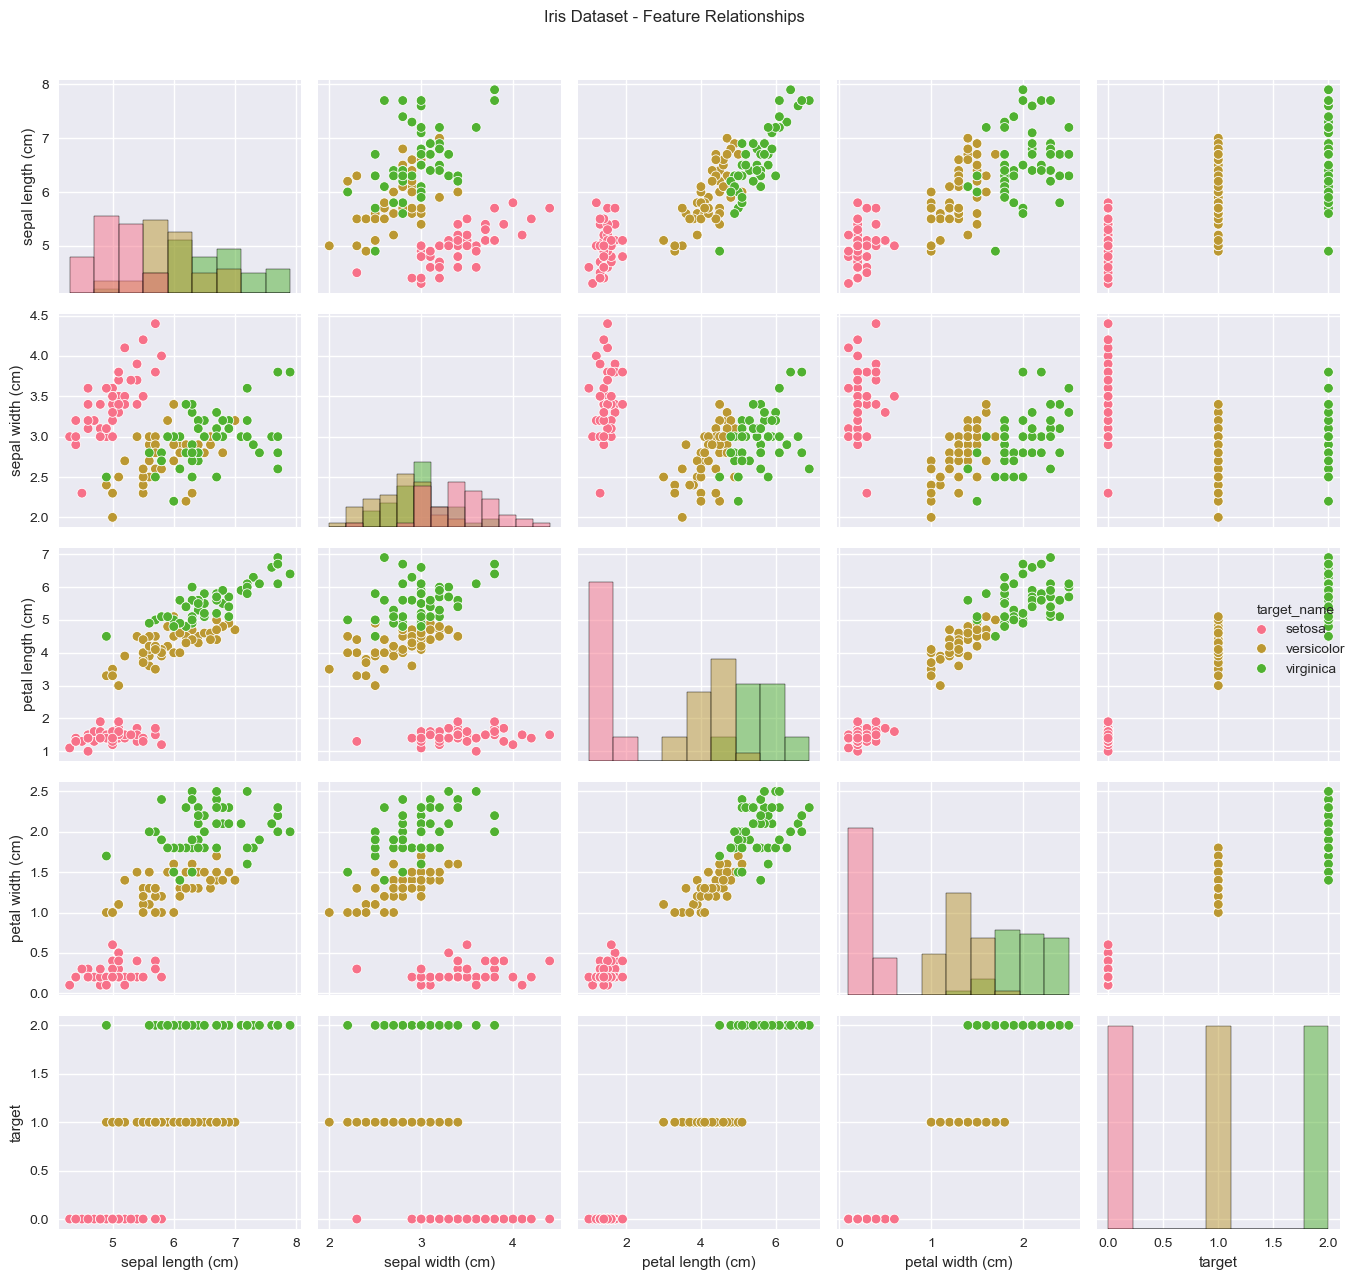

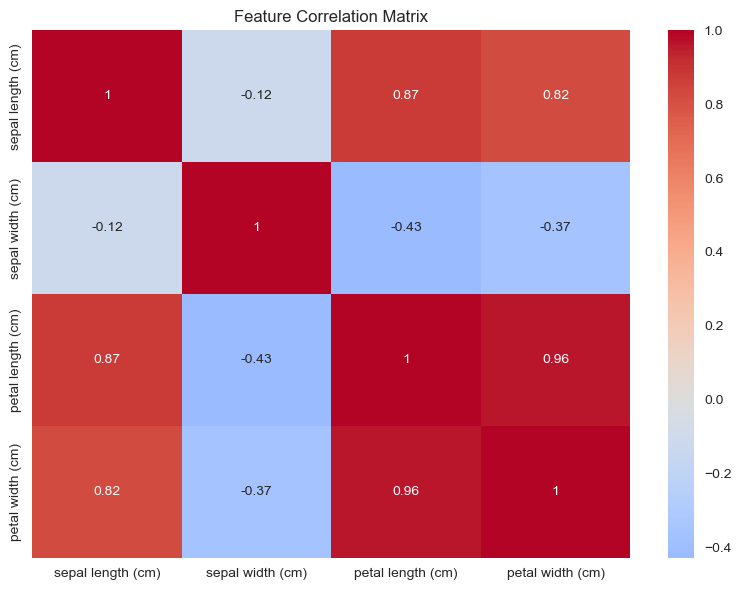

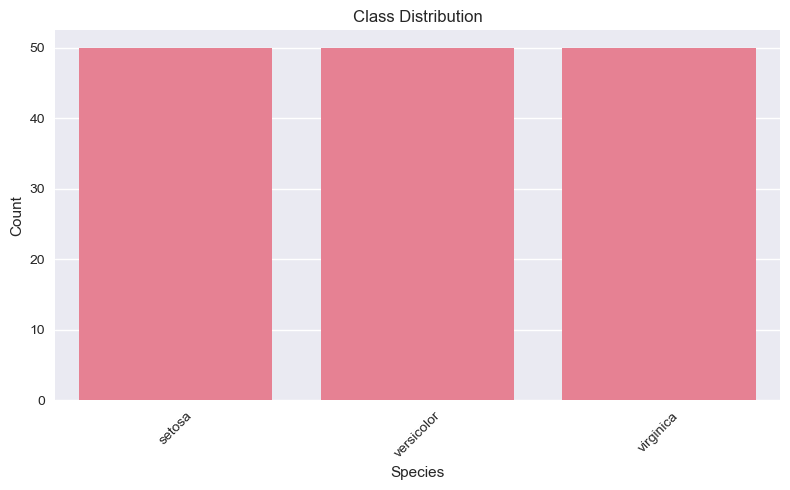


📊 Eğitim seti boyutu: (120, 4)
📊 Test seti boyutu: (30, 4)

🧠 Sinir Ağı Eğitiliyor...
🏗️  Mimari: Input(4) -> Hidden[10, 8] -> Output(3)
Epoch 10/200 - Loss: 0.8042 - Val Accuracy: 0.5417
Epoch 20/200 - Loss: 0.6390 - Val Accuracy: 0.7500
Epoch 30/200 - Loss: 0.5424 - Val Accuracy: 0.7917
Epoch 40/200 - Loss: 0.4706 - Val Accuracy: 0.7917
Epoch 50/200 - Loss: 0.4134 - Val Accuracy: 0.7917
Epoch 60/200 - Loss: 0.3660 - Val Accuracy: 0.7917
Epoch 70/200 - Loss: 0.3267 - Val Accuracy: 0.8333
Epoch 80/200 - Loss: 0.2934 - Val Accuracy: 0.8333
Epoch 90/200 - Loss: 0.2650 - Val Accuracy: 0.8333
Epoch 100/200 - Loss: 0.2408 - Val Accuracy: 0.8750
Epoch 110/200 - Loss: 0.2208 - Val Accuracy: 0.9167
Epoch 120/200 - Loss: 0.2035 - Val Accuracy: 0.9583
Epoch 130/200 - Loss: 0.1888 - Val Accuracy: 0.9583
Epoch 140/200 - Loss: 0.1757 - Val Accuracy: 0.9583
Epoch 150/200 - Loss: 0.1636 - Val Accuracy: 0.9583
Epoch 160/200 - Loss: 0.1534 - Val Accuracy: 0.9583
Epoch 170/200 - Loss: 0.1444 - Val Accu

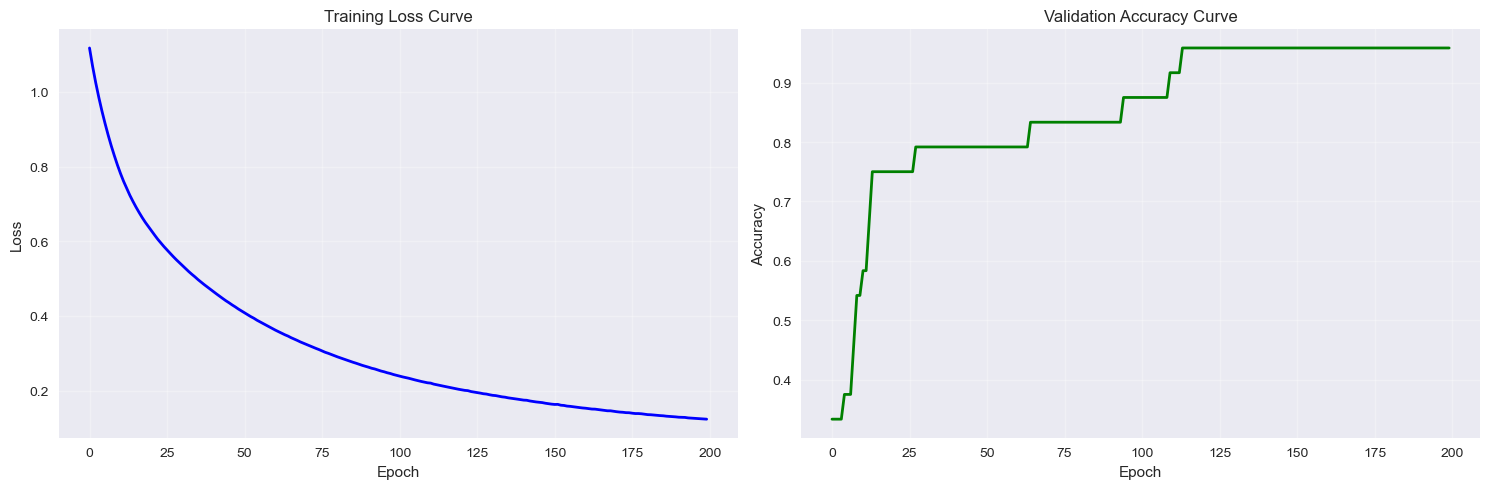


🔢 Karmaşıklık Matrisi Oluşturuluyor...


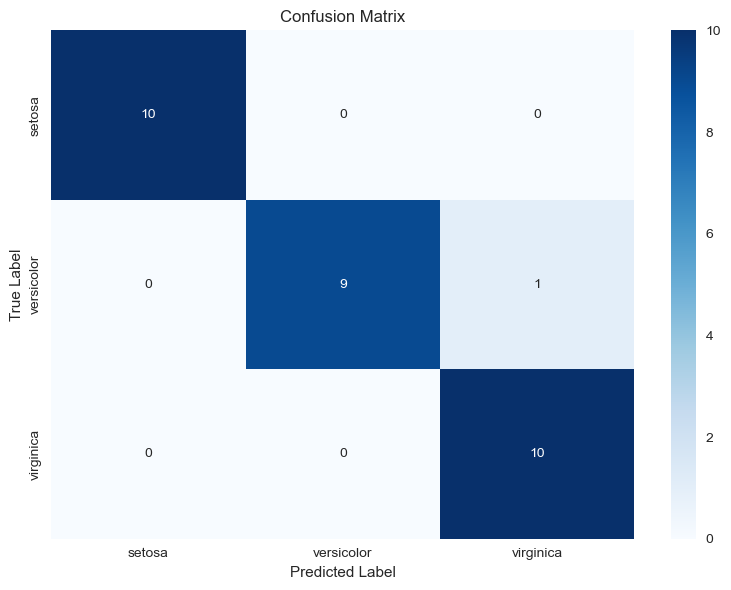

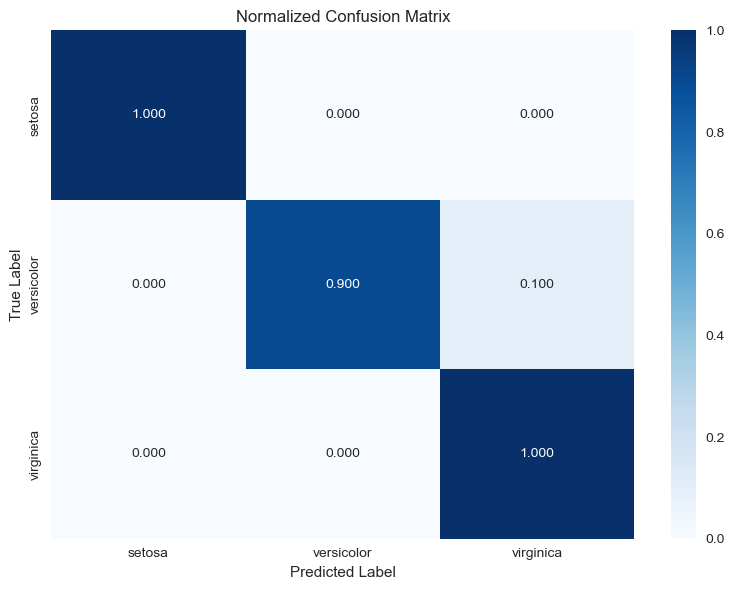


🎯 Tahmin Sonuçları Görselleştiriliyor...


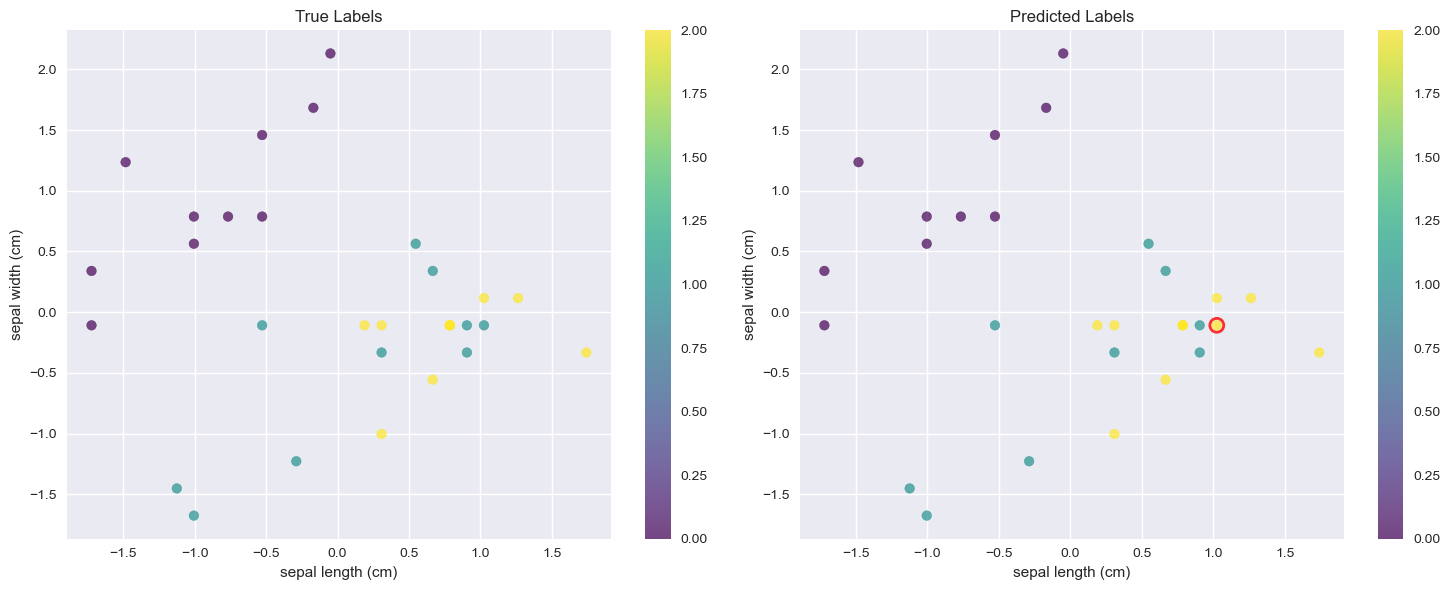


💾 Sonuçlar Kaydediliyor...

✅ Deney tamamlandı!
📁 Sonuçlar 'results/' klasörüne kaydedildi.
🎯 Final Test Accuracy: 0.9667


In [28]:
def main():
    """Ana fonksiyon"""
    print("🚀 Sinir Ağı Laboratuvar Çalışması Başlıyor!\n")
    
    # 1. Veri yükleme ve hazırlama
    X, y, df, feature_names, target_names = load_and_prepare_data()
    
    # 2. Veri görselleştirme
    visualize_data(df, feature_names, target_names)
    
    # 3. Veriyi böl ve normalize et
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Normalizasyon
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    print(f"\n📊 Eğitim seti boyutu: {X_train.shape}")
    print(f"📊 Test seti boyutu: {X_test.shape}")
    
    # 4. Model eğitimi
    model = train_neural_network(X_train, X_test, y_train, y_test)
    
    # 5. Model değerlendirme
    y_pred, y_pred_proba, accuracy = evaluate_model(model, X_test, y_test, target_names)
    
    # 6. Görselleştirmeler
    plot_training_history(model)
    plot_confusion_matrix(y_test, y_pred, target_names)
    plot_predictions(X_test, y_test, y_pred, y_pred_proba, feature_names, target_names)
    
    # 7. Sonuçları kaydet
    save_results_summary(accuracy, model, X_test, y_test, y_pred, target_names)
    
    print(f"\n✅ Deney tamamlandı!")
    print(f"📁 Sonuçlar 'results/' klasörüne kaydedildi.")
    print(f"🎯 Final Test Accuracy: {accuracy:.4f}")

if __name__ == "__main__":
    main()